In [1]:
%pylab inline
import numpy as np
import numpy.matlib as mm
from scipy.sparse import csr_matrix
from scipy import sparse as sp
import networkx as nx

Populating the interactive namespace from numpy and matplotlib


# 1. Make Network to Study

In [2]:
def ER_GNP(n,p): # Erdos-Renyi graph G(n,p)    
    A = np.random.rand(n,n) < p
    A = np.triu(A, k=1)
    return csr_matrix(A + A.T) #adjacency matrix

# A = ER_GNP(1000,.5) 
# A = uniform_weight_edges(A)
# plt.imshow(A,cmap='cool')
# plt.colorbar();

def make_SBM(Ns,PI):
    K = shape(PI)[0]     
    n = np.zeros(K+1,dtype=int)
    n[1:] = np.cumsum(Ns)
    ids = []
    for k in range(K):
        start = 0;
        ids.append(arange(n[k],n[k+1]))

    one_hot = np.zeros((n[-1],K),dtype = bool)
    for k in range(K):
        one_hot[ids[k],k] = True;

    A = np.random.rand(n[-1],n[-1]) < np.dot(np.dot(one_hot,PI),one_hot.T)
  
    A = np.triu(A,k=1)
    
    n = np.zeros(K+1,dtype=int)
    n[1:] = np.cumsum(Ns)
    id_sets = []
    for k in range(K):
        start = 0;
        id_sets.append(list(arange(n[k],n[k+1])))

    return  (A + A.T),id_sets

def uniform_weight_edges(A,mmax): # weight the edges
    N = np.shape(A)[0]
    w = np.random.rand(N,N)*mmax
    w = np.triu(w, k=1) + np.triu(w, k=1).T    
    
    
    #A = A.type(float)

    row,col,val = sp.find(A)
    A[row,col] = val * np.random.rand(len(val))*mmax

    
    return A * w


In [3]:
K = 4 # number communities

if K == 4:
    PI = 1/2*np.array([[.1,.05,.00,.00],
                      [.05,.1,.05,.00],
                      [.00,.05,.1,.05],
                      [.00,.001,.05,.1]])

if K == 8:
    PI = 1/4*np.array([[ .1,.05,.01, .0, .0, .0, .0, .0],
                      [.05, .1,.05,.01, .0, .0, .0, .0],
                      [.01,.05, .1,.05,.01, .0, .0, .0],
                      [ .0,.01,.05, .1,.05,.01, .0, .0],
                      [ .0, .0,.01,.05, .1,.05,.01, .0],
                      [ .0, .0, .0,.01,.05, .1,.05,.01],
                      [ .0, .0, .0, .0,.01,.05, .1,.05],
                      [ .0, .0, .0, .0, .0,.01,.05, .1]])


N = 50*K # nodes
Ns = np.ones(K,dtype=int)*N/K
A,id_sets = make_SBM(Ns,PI)
A = uniform_weight_edges(A,.1)

lam = np.max(np.linalg.eigh(A)[0])
lam

0.31745425671639027

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

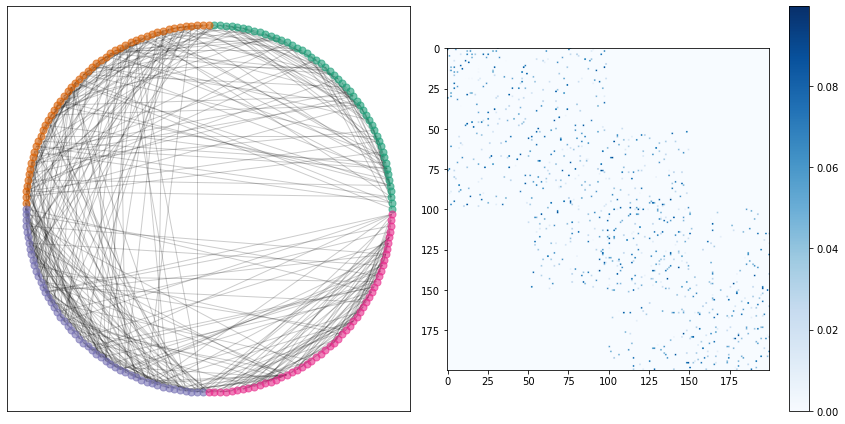

In [4]:
f1,ax = plt.subplots(1,2,figsize = (12,6))
cmap = plt.get_cmap('Dark2')
colors = [cmap(i) for i in range(4)]
#colors = Pastel1#['b','r','g','y']
G = nx.to_networkx_graph(A,create_using=nx.Graph())
pos = nx.circular_layout(G)
for t,ids in enumerate(id_sets):
    nx.draw_networkx_nodes(G,pos,nodelist = ids,ax=ax[0],node_size=50,node_color=colors[t],alpha=.6)
nx.draw_networkx_edges(G,pos,ax=ax[0],edge_size=2,node_color='k',alpha=.2)   
    
temp = ax[1].imshow(A,cmap='Blues')
cbar = plt.colorbar(temp);
plt.tight_layout()

# 2. Simulate SIS Epidemics

In [5]:
 def simulate_SIS(A,SIS_opts):    
    N = len(A)
    X = np.zeros((SIS_opts['T'],N))
    x = SIS_opts['x0'].copy()
    X[0] = x

    E = np.array(np.random.rand(SIS_opts['T'],N)<SIS_opts['eta'],dtype=int)# external excitation
    H = np.array(np.random.rand(SIS_opts['T'],N)<SIS_opts['beta'],dtype=int)# health recoveries
    
    for t in range(SIS_opts['T']-1):
        I =  np.array(np.random.rand(N,N)< A* SIS_opts['gamma'],dtype=int)# stochastic interactions
        xx = np.max(dot(I,np.diag(x)),1)        
        x = (1-x)*np.max(np.array([xx,E[t]]), 0) + x*(1-H[t])
        X[t+1] = x
    return X    

def get_p_curve(A,SIS_opts,gammas,delay):
    ps = zeros(len(gammas))
    for i,gamma in enumerate(gammas):
        print(i/len(gammas))
        SIS_opts['gamma'] = gamma
        X = simulate_SIS(A,SIS_opts)
        ps[i] = np.mean(X[delay:])
    return ps

def get_p_curves(A,SIS_opts,gammas,delay):
    ps = np.zeros((len(SIS_opts['etas']),len(gammas)))
    for i,eta in enumerate(SIS_opts['etas']):    
        print(i/len(SIS_opts['etas']))
        SIS_opts['eta'] = eta
        ps[i] = get_p_curve(A,SIS_opts,gammas,delay)
    return ps

def make_raster_plots(ax,Xs):
    cmaps = ['Oranges','Blues','Greys']
    for t,X in enumerate(Xs): 
        ax[t].imshow(X.T,interpolation='none',cmap=cmaps[t])
        ax[t].xaxis.tick_bottom()
        ax[t].set_xlabel('time, $t$')
    ax[0].set_ylabel('patch id, $i$')
    return 

In [6]:
x0 = np.zeros(len(A),dtype=int)
x0[int(len(A)/2)] = 1

SIS_opts = {'T':21, # number of discrete time steps
            'x0':x0, # initial condition
            'gamma':0.001, # spreading rate
            'beta':0.01, # recovery rate
            'eta':0.00005 # random activation rate
           }

gamma1 = .02
SIS_opts['gamma'] = gamma1
X1 = simulate_SIS(A,SIS_opts)

gamma2 = .05
SIS_opts['gamma'] = gamma2
X2 = simulate_SIS(A,SIS_opts)

In [7]:
SIS_opts['T'] = 50 # numnber of time steps
gammas = np.logspace(-1,1,20) * SIS_opts['beta']/lam
delay = 10 # how many time points to ignore before computing average activation
ps = get_p_curve(A,SIS_opts,gammas,delay)

0.0
0.05
0.1
0.15
0.2
0.25
0.3
0.35
0.4
0.45
0.5
0.55
0.6
0.65
0.7
0.75
0.8
0.85
0.9
0.95


In [8]:
def get_dom_eval_and_evec(A):
    evals,evecs = np.linalg.eigh(A)
    k = argmax(evals)
    lam = evals[k] # dominant eigenvalue
    u = abs(evecs.T[k]) # dominant eigenvector
    return lam,u

def rank_by_evec(A):
    _,u = get_dom_eval_and_evec(A)
    rank = argsort(-u)
    return rank

def distributed_rank_by_evec(A,id_sets):
    KK = len(id_sets)
    N = len(A)
    ranks = np.zeros((int(N/KK),KK),dtype=int)
    for t,ids in enumerate(id_sets):        
        ranks[:,t] = rank_by_evec((A[ids].T)[ids]) + t*int(N/KK)
            
    ranks = ranks.flatten()
    return ranks

def create_and_mask(N,ids):
    mask = np.zeros(N,dtype=bool)
    mask[ids] = True
    mask = mm.repmat(mask,N,1)          
    return np.logical_and(mask,mask.T)

def create_or_mask(N,ids):
    mask = np.zeros(N,dtype=bool)
    mask[ids] = True
    mask = mm.repmat(mask,N,1)          
    return np.logical_or(mask,mask.T)

In [9]:
def get_node_ranks(A,rank_opts):
    
    if rank_opts['type']=='random': # select node uniformly at random
        ranks = random.permutation(len(A))
        
    if rank_opts['type']=='evec': # select node by eigenvector centrality
        _,u = get_dom_eval_and_evec(A)
        ranks = argsort(-u)
            
    if rank_opts['type']=='distributed_evec': # select node by distributed eigenvector centralities
        ranks = distributed_rank_by_evec(A,rank_opts['id_sets'])
        
    if rank_opts['type']=='custom': # allow input of any function with any arguments
        ranks = rank_opts['function'](A,rank_opts['arguments'])
        
    return ranks 

In [10]:
def decrease_nodes_weights(A,node_ids,p=.5):
    mask = create_or_mask(N,node_ids)# the weights of these edges will decrease
    return A - (mask*A)*p 

def decrease_top_nodes_weights(A,k,rank_opts,p=0.5):
    ranks = get_node_ranks(A,rank_opts)
    AA  = decrease_nodes_weights(A,ranks[:k],p)
    return AA

def manage_nodes(A,Ks,rank_opts,manage_opts):
    
    #compute ranks just once
    if manage_opts['online']==False:
        ranks = get_node_ranks(A,rank_opts)
        #print(ranks[:4])
        lams = np.zeros(len(Ks))
        for t,k in enumerate(Ks):
            AA  = decrease_nodes_weights(A,node_ids=ranks[:k],p=manage_opts['p'])
            lams[t],_ = get_dom_eval_and_evec(AA)
            
    if manage_opts['online']==True:
        AA = A.copy()
        lams = np.ones(len(Ks))
        for t,k in enumerate(Ks):
            lams[t],_ = get_dom_eval_and_evec(AA)
            AA = decrease_top_nodes_weights(AA,Ks[1]-Ks[0],rank_opts,p=manage_opts['p'])
    
    return AA,lams

In [11]:
p = 0.7
KK = 64
Ks = arange(0,KK,K)

rank_opts = {'type':'random' # rank completely at random
            }

manage_opts = {'p':p, # decrease the edge weights of selected nodes by p% (p=1 is the strongest management) 
               'online':False, # update ranking after each modification?
               'distributed':False # compute rankings separately for different subgraphs
              }

A_random,lams_random = manage_nodes(A,Ks,rank_opts,manage_opts)

In [12]:
manage_opts = {'p':p, # decrease the edge weights of selected nodes by p% (p=1 is the strongest management) 
               'online':True, # update ranking after each modification?
               'distributed':False # compute rankings separately for different subgraphs
              }

rank_opts = {'type':'evec', # rank according to eigenvector centrality
            }

manage_opts['online'] = True
AA,lams = manage_nodes(A,Ks,rank_opts,manage_opts)

manage_opts['online'] = False
AA2,lams2 = manage_nodes(A,Ks,rank_opts,manage_opts)


import importlib
import manage as m
importlib.reload(m)

b = ceil(KK / K)
rank_optst = rank_opts.copy()
rank_optst['budget'] = np.repeat(b, K)
rank_optst['control_id_sets'] = [np.arange(len(A))] # global control
manage_optst = manage_opts.copy()

b = rank_optst['budget']

manage_optst['online'] = True # update ranking after each modification? yes
AAt,lamst = m.manage_nodes(A,rank_optst,manage_optst)

manage_optst['online'] = False # update ranking after each modification? kjjyes
AA2t,lams2t = m.manage_nodes(A,rank_optst,manage_optst)

ranks = m.flatten_ranks(m.get_info_to_rank(rank_optst)(A))
assert all(0 == r for r in ranks -get_node_ranks(A, rank_opts))


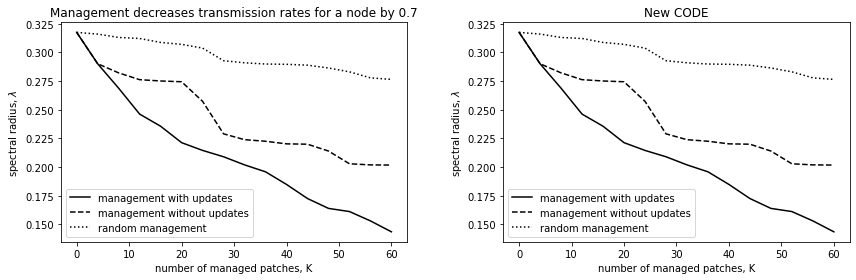

In [13]:

#plot(arange(K),lams[0]*np.ones(K),'k:')
f1,ax = plt.subplots(1,2,figsize=(12,4));

ax[0].plot(Ks,lams,'k')
ax[0].plot(Ks,lams2,'k--')
ax[0].plot(Ks,lams_random,'k:')
ax[0].legend(['management with updates','management without updates','random management'])

ax[0].set_xlabel('number of managed patches, K')
ax[0].set_ylabel('spectral radius, $\lambda$')

ax[0].set_title('Management decreases transmission rates for a node by '+ str(manage_opts['p']));

ax[1].plot(Ks,lamst,'k')
ax[1].plot(Ks,lams2t,'k--')
ax[1].plot(Ks,lams_random,'k:')
ax[1].legend(['management with updates','management without updates','random management'])

ax[1].set_xlabel('number of managed patches, K')
ax[1].set_ylabel('spectral radius, $\lambda$')

ax[1].set_title('New CODE')


plt.tight_layout();


In [14]:
manage_opts = {'p':p, # decrease the edge weights of selected nodes by p% (p=1 is the strongest management) 
               'distributed':True # compute rankings separately for different subgraphs
              }

rank_opts = {'type':'distributed_evec', # rank according to distributes eigenvector centrality
             'id_sets':id_sets
            }

manage_opts['online'] = True # update ranking after each modification? yes
AA3,lams3 = manage_nodes(A,Ks,rank_opts,manage_opts)


manage_opts['online'] = False # update ranking after each modification? no
AA4,lams4 = manage_nodes(A,Ks,rank_opts,manage_opts)



b = ceil(KK / K)
rank_optst = rank_opts.copy()
rank_optst['budget'] = np.repeat(b, K)
rank_optst['info_id_sets'] = [np.array(i) for i in id_sets]
rank_optst['control_id_sets'] = [np.array(i) for i in id_sets]
manage_optst = manage_opts.copy()

manage_optst['online'] = True # update ranking after each modification? yes
AA3t,lams3t = m.manage_nodes(A,rank_optst,manage_optst)
manage_optst['online'] = False # update ranking after each modification? yes
AA4t,lams4t = m.manage_nodes(A,rank_optst,manage_optst)


ranks = m.flatten_ranks(m.get_info_to_rank(rank_optst)(A))
assert all(0 == r for r in ranks -get_node_ranks(A, rank_opts))

#tmp = m.get_info_to_rank(rank_optst)(A)
#tmp = list(tmp)
#tmp2 = [t[np.isin(t, i)] for t, i in zip(list(tmp), rank_optst['info_id_sets']) ]
#[t-t2 for t, t2 in zip(tmp, tmp2)]

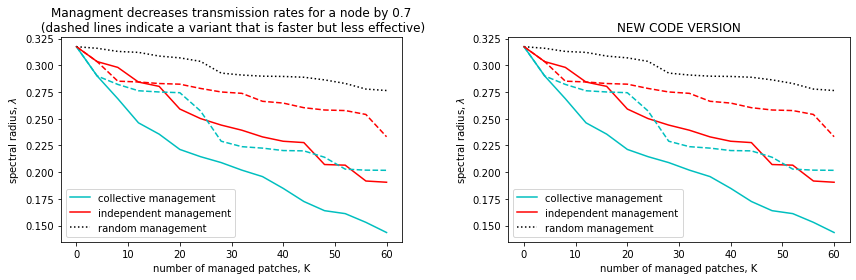

In [15]:
f1,ax = plt.subplots(1,2,figsize=(12,4));

ax[0].plot(Ks,lams,'c')
ax[0].plot(Ks,lams3,'r')
ax[0].plot(Ks,lams_random,'k:');
ax[0].legend(['collective management','independent management','random management'])

ax[0].plot(Ks,lams2,'c--')
ax[0].plot(Ks,lams4,'r--');

ax[0].set_xlabel('number of managed patches, K')
ax[0].set_ylabel('spectral radius, $\lambda$')

ax[0].set_title('Managment decreases transmission rates for a node by '+ str(manage_opts['p']) +'\n (dashed lines indicate a variant that is faster but less effective)');

ax[1].plot(Ks,lams,'c')
ax[1].plot(Ks,lams3t,'r')
ax[1].plot(Ks,lams_random,'k:');
ax[1].legend(['collective management','independent management','random management'])

ax[1].plot(Ks,lams2,'c--')
ax[1].plot(Ks,lams4t,'r--');

ax[1].set_xlabel('number of managed patches, K')
ax[1].set_ylabel('spectral radius, $\lambda$')

ax[1].set_title('NEW CODE VERSION')

plt.tight_layout();


## Stop here with assertion error to avoid-long runding code dependent on simulation


In [16]:
assert False  

AssertionError: 

In [ ]:
lam_AA = np.max(np.linalg.eigh(AA)[0])
lam_AAt = np.max(np.linalg.eigh(AAt)[0])

print(SIS_opts['beta']/lam_AA)

lam_AA3 = np.max(np.linalg.eigh(AA3)[0])
lam_AA3t = np.max(np.linalg.eigh(AA3t)[0])

print(SIS_opts['beta']/lam_AA3)

In [ ]:
SIS_opts['T'] = 210 # numnber of time steps
delay = 10 # how many time points to ignore before computing average activation
x0 = np.zeros(len(A),dtype=int)
x0[int(len(AA)/2)] = 1

np.random.seed(1)
ps_AA = get_p_curve(AA,SIS_opts,gammas,delay)

np.random.seed(1)
ps_AAt = get_p_curve(AAt,SIS_opts,gammas,delay)

In [ ]:
np.random.seed(1)
ps_AA3 = get_p_curve(AA3,SIS_opts,gammas,delay)
np.random.seed(1)
ps_AA3t = get_p_curve(AA3t,SIS_opts,gammas,delay)

In [ ]:
f1,ax = plt.subplots(1,2,figsize=(12,4));
ax[0].loglog(gammas,ps,'b',linewidth=2)
ax[0].loglog(gammas,ps_AA,'c',linewidth=2)
ax[0].loglog(gammas,ps_AA3,'r',linewidth=2)
ax[0].legend(['unmanaged','collectively managed','independently managed'])
ax[0].set_title('Infected fraction at steady state')
ax[0].set_ylabel('steady state, $p$')
ax[0].set_xlabel('spreading rate, $\gamma$')
ax[0].plot([SIS_opts['beta']/lam,SIS_opts['beta']/lam],[.006,1],'b:')
ax[0].plot([SIS_opts['beta']/lam_AA,SIS_opts['beta']/lam_AA],[.006,1],'c:')
ax[0].plot([SIS_opts['beta']/lam_AA3,SIS_opts['beta']/lam_AA3],[.006,1],'r:')

ax[1].semilogx(gammas,ps_AA3/ps_AA,'k',linewidth=2)
ax[0].plot([SIS_opts['beta']/lam,SIS_opts['beta']/lam],[.006,1],'b:')
ax[1].plot([SIS_opts['beta']/lam_AA,SIS_opts['beta']/lam_AA],[.5,2],'c:')
ax[1].plot([SIS_opts['beta']/lam_AA3,SIS_opts['beta']/lam_AA3],[.5,2],'r:')
ax[1].set_title('Ratio of infections: independent vs collective management')
ax[1].set_ylabel('ratio, $\phi$')
ax[1].set_xlabel('spreading rate, $\gamma$')
ax[1].text(.01,1.6,s='Infection can be \ntwice as large \nwithout collective \nmanagement')
plt.tight_layout();


In [ ]:
f1,ax = plt.subplots(1,2,figsize=(12,4));
ax[0].loglog(gammas,ps,'b',linewidth=2)
ax[0].loglog(gammas,ps_AAt,'c',linewidth=2)
ax[0].loglog(gammas,ps_AA3t,'r',linewidth=2)
ax[0].legend(['unmanaged','collectively managed','independently managed'])
ax[0].set_title('NEW CODE')
ax[0].set_ylabel('steady state, $p$')
ax[0].set_xlabel('spreading rate, $\gamma$')
ax[0].plot([SIS_opts['beta']/lam,SIS_opts['beta']/lam],[.006,1],'b:')
ax[0].plot([SIS_opts['beta']/lam_AAt,SIS_opts['beta']/lam_AAt],[.006,1],'c:')
ax[0].plot([SIS_opts['beta']/lam_AA3t,SIS_opts['beta']/lam_AA3t],[.006,1],'r:')

ax[1].semilogx(gammas,ps_AA3t/ps_AAt,'k',linewidth=2)
ax[0].plot([SIS_opts['beta']/lam,SIS_opts['beta']/lam],[.006,1],'b:')
ax[1].plot([SIS_opts['beta']/lam_AAt,SIS_opts['beta']/lam_AAt],[.5,2],'c:')
ax[1].plot([SIS_opts['beta']/lam_AA3t,SIS_opts['beta']/lam_AA3t],[.5,2],'r:')
ax[1].set_title('NEW CODE')
ax[1].set_ylabel('ratio, $\phi$')
ax[1].set_xlabel('spreading rate, $\gamma$')
plt.tight_layout();
